# Auto-Complete/Language Modelling using N-Gram 

In this notebook, I will show you how to do language modelling or predict the next word in the sequence using what is a pretty simple NLP algorithm called N-grams. Which forms a very basic form of an autocomplete model.   

Everything will be implemented in PyTorch. Unlike a traditional N-Gram model we'll use a Neural Network to extimate the probability of the next word from the vocabulary.

First up, we will see about trigrams where the previous 2 words are taken for context.

In [1]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
plt.style.use("ggplot")

%matplotlib inline

import requests
import re
import pkbar

import os

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

> **Note: We will be using Charles Dickens' great novel "A Tale of two cities" to train our model.**

You can download the novel using the script below, or from [this link](https://www.gutenberg.org/files/98/98-0.txt)

If you decide to download from the website, make sure to remove unwanted text from gutenberg at the start and end of the txt file. However I have included the txt file with all the changes in this repo. 

In [3]:
if "tale_of_2_cities.txt" not in os.listdir():
    url = "https://www.gutenberg.org/files/98/98-0.txt"
    r = requests.get(url)

    if r.status_code == 200:
        with open("tale_of_2_cities.txt", "wb") as f:
            f.write(r.content)

with open("tale_of_2_cities.txt", "r", encoding="utf-8") as f:
    book = f.read()

book = re.sub('\n', ' ', book)
book = re.sub('\ufeff', '', book)

In [4]:
train_text = book.lower().split()
print(train_text[:10])

['i.', 'the', 'period', 'it', 'was', 'the', 'best', 'of', 'times,', 'it']


## Neural N-gram model PyTorch

In [5]:
class NGramModel(nn.Module):
    """
    A simple Neural Network - for the sake of this tutorial
    """
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)
        
    def forward(self, inputs):
        embeds = self.embedding(inputs).view((1, -1))
        x = F.relu(self.linear1(embeds))
        x = self.linear2(x)
        log_probs = F.log_softmax(x, dim=1)
        return log_probs

## Trigram

In [6]:
make_trigrams = lambda text: [([text[i], text[i+1]], text[i+2]) for i in range(len(text) -2)]

trigrams = make_trigrams(train_text)

In [7]:
trigrams[:3]

[(['i.', 'the'], 'period'),
 (['the', 'period'], 'it'),
 (['period', 'it'], 'was')]

In [8]:
vocabulary = set(train_text)
vocab_len = len(vocabulary)

word_ixs = {word: i for i, word in enumerate(vocabulary)}

print(f"Vocabulary Length: {vocab_len}")

Vocabulary Length: 18131


In [9]:
EPOCHS = 10
EMBED_DIM = 32
CONTEXT_LEN = 2  

model = NGramModel(vocab_len, EMBED_DIM, CONTEXT_LEN).to(device)

losses = []
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-02)

for epoch in range(EPOCHS):
    tot_loss = 0
    
    # Keras style progress bar in PyTorch
    kbar = pkbar.Kbar(target=len(trigrams), epoch=epoch, num_epochs=EPOCHS, width=20, always_stateful=False)

    for i, (context, targets) in enumerate(trigrams):
        # Process the inputs
        idxs = torch.tensor([word_ixs[w] for w in context], dtype=torch.long, device=device)
        
        # Reset gradients 
        model.zero_grad()
        
        # Forward pass
        log_probs = model(idxs)
        
        # compute loss
        loss = loss_function(log_probs, torch.tensor([word_ixs[targets]], dtype=torch.long, device=device))
        
        # backprop and update grads
        loss.backward()
        optimizer.step()
        
        tot_loss += loss.item()
        
        kbar.update(i, values=[("loss", loss.item())])
        
    kbar.add(1)
        
    losses.append(tot_loss / len(train_text))

Epoch: 1/10
135595/135595 [====================] - 246s 2ms/step - loss: 6.8903
Epoch: 2/10
135595/135595 [====================] - 192s 1ms/step - loss: 6.3981
Epoch: 3/10
135595/135595 [====================] - 185s 1ms/step - loss: 6.1157
Epoch: 4/10
135595/135595 [====================] - 185s 1ms/step - loss: 5.8585
Epoch: 5/10
135595/135595 [====================] - 186s 1ms/step - loss: 5.6098
Epoch: 6/10
135595/135595 [====================] - 180s 1ms/step - loss: 5.3700
Epoch: 7/10
135595/135595 [====================] - 179s 1ms/step - loss: 5.1443
Epoch: 8/10
135595/135595 [====================] - 184s 1ms/step - loss: 4.9392
Epoch: 9/10
135595/135595 [====================] - 186s 1ms/step - loss: 4.7575
Epoch: 10/10
135595/135595 [====================] - 185s 1ms/step - loss: 4.5986


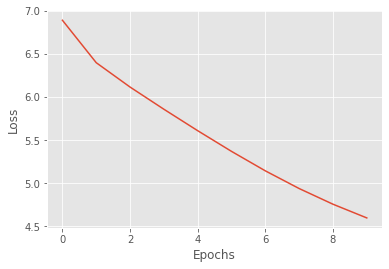

In [10]:
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [11]:
def make_inference(inputs, word_dict):
    # Re-map dict
    reverted_dict = dict(map(reversed, word_ixs.items()))
    
    model.eval()
    with torch.no_grad():
        # Processing input
        idxs = torch.tensor([word_dict[w] for w in inputs], dtype=torch.long, device=device)
        
        # Forward pass
        log_probs = model(idxs)
        
        # Obtain probs
        probs = torch.exp(log_probs)
        
        # obtain prediction
        _, pred = torch.max(probs, 1)
        
        # Obtain predicted word index
        pred_idx = pred.detach().cpu().numpy()[0]
        
        # Get predicted word from remapped dict
        out = reverted_dict[pred_idx]
        
    return pred_idx, out

In [12]:
def generate_text(inputs, word_dict, n_words):
    # Preprocess input
    inputs = inputs.lower().split()
    
    # Keep track of predicted words
    pred_sent = inputs
    # Collect pred indexes
    pred_idxs = []
    
    for w in range(n_words):
        pred_idx, pred_w = make_inference(inputs, word_dict)
        pred_sent.append(pred_w)
        pred_idxs.append(pred_idx)
        inputs = [pred_sent[-2], pred_sent[-1]]
    
    return pred_sent, pred_idxs

In [13]:
print(generate_text("I am", word_ixs, 10))
print(generate_text("London is", word_ixs, 10))
print(generate_text("A king", word_ixs, 10))
print(generate_text("After that", word_ixs, 10))

(['i', 'am', 'a', 'briton,”', 'of', 'their', 'descendants,', 'generations', 'hence.', 'a', 'wife', 'of'], [6288, 2657, 10975, 9486, 9753, 6821, 4946, 6288, 3177, 10975])
(['london', 'is', 'a', 'far,', 'far', 'better', 'rest', 'that', 'i', 'have', 'ever', 'known.”'], [6288, 5933, 10319, 14791, 3555, 13860, 898, 3477, 14564, 9098])
(['a', 'king', 'see', 'a', 'beautiful', 'of', 'a', 'drowning', 'woman.', 'soon,', 'i', 'see'], [12140, 6288, 16344, 10975, 6288, 13529, 11596, 4183, 898, 12140])
(['after', 'that', 'i', 'have', 'ever', 'known.”', 'a', 'flash', 'of', 'this', "day's", 'disfigurement--and'], [898, 3477, 14564, 9098, 6288, 6828, 10975, 15525, 12125, 8700])


In [19]:
print(generate_text("Who is", word_ixs, 10)[0])

['who', 'is', 'the', 'natural', 'birth,', 'a', 'child', 'upon', 'it,', 'of', 'the', 'tumbrils,']


## N-Gram

In [35]:
# Making ngrams is also easy, you should be using (n-1) in slicing, Sorry for that! 
make_n_grams = lambda text, n: [(text[i:i+n], text[i+n]) for i in range(len(text) - n)]

N = 8 

n_grams = make_n_grams(train_text, N)

In [36]:
n_grams[:3]

[(['i.', 'the', 'period', 'it', 'was', 'the', 'best', 'of'], 'times,'),
 (['the', 'period', 'it', 'was', 'the', 'best', 'of', 'times,'], 'it'),
 (['period', 'it', 'was', 'the', 'best', 'of', 'times,', 'it'], 'was')]

In [39]:
EPOCHS = 10
EMBED_DIM = 32
CONTEXT_LEN = N  

model = NGramModel(vocab_len, EMBED_DIM, CONTEXT_LEN).to(device)

losses = []
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-02)

for epoch in range(EPOCHS):
    tot_loss = 0
    kbar = pkbar.Kbar(target=len(n_grams), epoch=epoch, num_epochs=EPOCHS, width=20, always_stateful=False)

    for i, (context, targets) in enumerate(n_grams):
        # Process the inputs
        idxs = torch.tensor([word_ixs[w] for w in context], dtype=torch.long, device=device)
        
        # Reset gradients 
        model.zero_grad()
        
        # Forward pass
        log_probs = model(idxs)
        
        # compute loss
        loss = loss_function(log_probs, torch.tensor([word_ixs[targets]], dtype=torch.long, device=device))
        
        # backprop and update grads
        loss.backward()
        optimizer.step()
        
        tot_loss += loss.item()
        
        kbar.update(i, values=[("loss", loss.item())])
        
    kbar.add(1)
        
    losses.append(tot_loss / len(train_text))

Epoch: 1/10
135589/135589 [====================] - 183s 1ms/step - loss: 7.0529
Epoch: 2/10
135589/135589 [====================] - 184s 1ms/step - loss: 6.5109
Epoch: 3/10
135589/135589 [====================] - 184s 1ms/step - loss: 6.1558
Epoch: 4/10
135589/135589 [====================] - 184s 1ms/step - loss: 5.8284
Epoch: 5/10
135589/135589 [====================] - 187s 1ms/step - loss: 5.5033
Epoch: 6/10
135589/135589 [====================] - 182s 1ms/step - loss: 5.1823
Epoch: 7/10
135589/135589 [====================] - 187s 1ms/step - loss: 4.8792
Epoch: 8/10
135589/135589 [====================] - 185s 1ms/step - loss: 4.6082
Epoch: 9/10
135589/135589 [====================] - 183s 1ms/step - loss: 4.3817
Epoch: 10/10
135589/135589 [====================] - 187s 1ms/step - loss: 4.1983


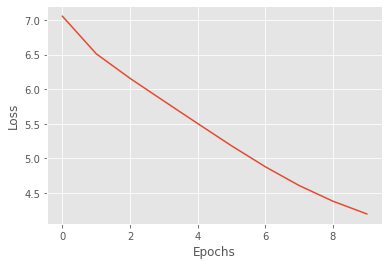

In [40]:
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [46]:
def generate_text_ngram(inputs, word_dict, n_words):
    # Preprocess input
    inputs = inputs.lower().split()
    
    # Get n, to slice out last n words from the predicted sentence
    n = len(inputs)
    
    # Keep track of predicted words
    pred_sent = inputs
    # Collect pred indexes
    pred_idxs = []
    
    for w in range(n_words):
        pred_idx, pred_w = make_inference(inputs, word_dict)
        pred_sent.append(pred_w)
        pred_idxs.append(pred_idx)
        inputs = pred_sent[-n:]
    
    return pred_sent, pred_idxs

In [60]:
print(generate_text_ngram("Yes, sir. We have oftentimes the honour to", word_ixs, 10))

(['yes,', 'sir.', 'we', 'have', 'oftentimes', 'the', 'honour', 'to', 'see', 'a', 'child', 'their', 'hearts', 'of', 'all', 'that', 'i', 'i'], [12140, 6288, 12757, 9486, 11971, 10975, 17930, 13860, 898, 898])


In [63]:
print(generate_text_ngram("You know that your parents had a great", word_ixs, 10))

(['you', 'know', 'that', 'your', 'parents', 'had', 'a', 'great', 'hand', 'and', 'a', 'long', 'of', 'a', 'curator', 'and', 'in', 'a'], [14824, 13983, 6288, 7477, 10975, 6288, 3018, 13983, 12195, 6288])


In [65]:
print(generate_text_ngram("London is a place where I'd love to", word_ixs, 10))

(['london', 'is', 'a', 'place', 'where', "i'd", 'love', 'to', 'be', 'the', 'tumbrils', 'i', 'see', 'that', 'i', 'know', 'a', 'patient'], [5318, 14727, 10065, 898, 12140, 13860, 898, 15928, 6288, 7491])


In [69]:
print(generate_text_ngram("A large cask of wine has been dropped", word_ixs, 10))

(['a', 'large', 'cask', 'of', 'wine', 'has', 'been', 'dropped', 'by', 'i', 'will', 'have', 'ever', 'gone', 'that', 'i', 'have', 'been'], [9591, 898, 6769, 3477, 14564, 18029, 13860, 898, 3477, 2450])


In [71]:
# Save (only) the model parameters
torch.save(model.state_dict(), 'ngram_model_trained.ckpt')

As you can see, the model is slightly better at predicting next words now, and a bit funny to be honest! This will definitely improve if you use a more complex algorithm and other SOTA approaches. 

Thanks for reading.

Contributor: [abhinand5](https://github.com/abhinand5)